In [1]:
## Relevant modules.
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations 

In [2]:
## Reading file.
file = 'data/data_panel.csv'
panel = pd.read_csv(file, header=0)

## Group with 4 specialties, 2 departments and 5 years.
## This group has more than 30 observations (doctors)...
## ...for each specialty in each department in each year.

group_1 = panel.groupby(['spec_code','dep_code','year'])[['doc_code']].count()
group_1.rename(columns={'doc_code': 'doc_count'}, inplace=True)
group_1 = group_1[group_1['doc_count'] > 30].reset_index()

group_2 = group_1.groupby(['spec_code','dep_code'])[['year']].count()
group_2.rename(columns={'year': 'year_count'}, inplace=True)
group_2 = group_2[group_2['year_count'] == 5].reset_index()

group_3 = group_2.groupby(['spec_code'])[['dep_code']].count()
group_3.rename(columns={'dep_code': 'dep_count'}, inplace=True)
group_3 = group_3[group_3['dep_count'] > 1].reset_index()

merge_3_2 = pd.merge(group_3, group_2, on=['spec_code'])
merge_3_2_1 = pd.merge(merge_3_2, group_1, on=['spec_code','dep_code'])
group = merge_3_2_1.drop(['year_count','dep_count'], axis=1)

## Subpanel from original panel taking into account only the above group.
## There are 2552 entries instead of 8294 entries. 
## Variable surgeries2visits and dummies for each specialty and department are created.

subpanel = pd.merge(panel, group, on=['spec_code','dep_code','year'])
subpanel.drop('doc_count', axis=1, inplace=True)
subpanel['surgeries2visits']=subpanel['n_surgeries']/subpanel['n_visits']

dummies = pd.get_dummies(subpanel[['spec_en','department']])
dummies_old_names = list(dummies.columns.values)
dummies_new_names = []

for i in dummies_old_names:
    if i[0:4] == 'spec':
        dummies_new_names.append(i[0:4]+i[7:11])
    elif i[0:4] == 'depa':
        dummies_new_names.append(i[0:3]+i[10:14])

dummies_dic_names = dict(zip(dummies_old_names, dummies_new_names))
dummies.rename(columns=dummies_dic_names,inplace=True)

subpanel = pd.concat([subpanel,dummies],axis=1)
print(subpanel.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2552 entries, 0 to 2551
Data columns (total 19 columns):
doc_code            2552 non-null int64
spec_code           2552 non-null int64
spec_es             2552 non-null object
spec_en             2552 non-null object
year                2552 non-null int64
n_visits            2552 non-null int64
n_surgeries         2552 non-null int64
n_patients          2552 non-null int64
c_visit             2552 non-null float64
c_surgery           2552 non-null float64
dep_code            2552 non-null int64
department          2552 non-null object
surgeries2visits    2552 non-null float64
spec_der            2552 non-null uint8
spec_gyn            2552 non-null uint8
spec_oph            2552 non-null uint8
spec_oto            2552 non-null uint8
dep_ant             2552 non-null uint8
dep_val             2552 non-null uint8
dtypes: float64(3), int64(7), object(3), uint8(6)
memory usage: 294.1+ KB
None


Using supervised classification to predict excessive number of surgeries.  
First, we need to define what excessive number of surgeries should be.  
We need to pay attention to the fact that number of surgeries is not normally distributed.

count    2552.000000
mean       20.603840
std        36.551873
min         1.000000
25%         2.750000
50%         7.000000
75%        21.000000
max       447.000000
Name: n_surgeries, dtype: float64


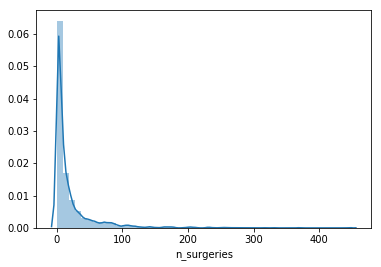

In [3]:
print(subpanel['n_surgeries'].describe())
fig = sns.distplot(subpanel['n_surgeries'])

Because number of surgeries is not normally distributed, instead of using mean and std, we are going to use a certain percentile to define the threshold of what constitutes excessive number of surgeries.

In [4]:
v_percentile = 70
surgeries_threshold = np.percentile(subpanel['n_surgeries'], v_percentile)
subpanel['ex_surgeries'] = [1 if i >= surgeries_threshold
                            else 0 for i in subpanel['n_surgeries']]

print('New variable: ex_surgeries (excessive surgeries).')
print('Criterion for ex_surgeries = 1:')
print('n_surgeries >= than the',v_percentile,'percentile.\n')
print(subpanel['ex_surgeries'].describe())

New variable: ex_surgeries (excessive surgeries).
Criterion for ex_surgeries = 1:
n_surgeries >= than the 70 percentile.

count    2552.000000
mean        0.306426
std         0.461099
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: ex_surgeries, dtype: float64


Now we are going to perform different types of supervised classification.

In [5]:
## Getting the necessary modules (tools).
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report

In [6]:
## Defining attributes X and target y.
X_list = ['n_visits','spec_gyn','spec_oph','spec_oto','dep_ant','year']
X = subpanel[X_list].astype(float).values
y = subpanel['ex_surgeries'].astype(float).values

In [7]:
## Using logistic regression.

## Setup the pipeline.
steps = [('scaler', StandardScaler()),
         ('logreg', LogisticRegression(solver='lbfgs'))]
pipeline = Pipeline(steps)

## Specify the hyperparameter space.
c_space = np.linspace(0.01, 20, 100)
parameters = {'logreg__C':c_space}

## Create train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=5)

## Instantiate the GridSearchCV object: cv.
cv = GridSearchCV(pipeline, param_grid=parameters, cv=5)

## Fit to the training set.
cv.fit(X_train, y_train)

## Predict the labels of the test set: y_pred.
y_pred = cv.predict(X_test)

## Compute and print metrics.
print('Using logistic regression.')
print("Accuracy: {}".format(cv.score(X_test, y_test)))
print(classification_report(y_test, y_pred))
print("Tuned Model Parameters: {}".format(cv.best_params_))

Using logistic regression.
Accuracy: 0.8714733542319749
              precision    recall  f1-score   support

         0.0       0.88      0.94      0.91       449
         1.0       0.83      0.71      0.77       189

   micro avg       0.87      0.87      0.87       638
   macro avg       0.86      0.82      0.84       638
weighted avg       0.87      0.87      0.87       638

Tuned Model Parameters: {'logreg__C': 0.21191919191919192}


In [8]:
## Using k-NN: k-nearest neighbors.

## Setup the pipeline.
steps = [('scaler', StandardScaler()),
         ('knn', KNeighborsClassifier())]
pipeline = Pipeline(steps)

## Specify the hyperparameter space.
n_neighbors_space = np.linspace(1, 20, 20).astype(int)
parameters = {'knn__n_neighbors':n_neighbors_space}

## Create train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=5)

## Instantiate the GridSearchCV object: cv.
cv = GridSearchCV(pipeline, param_grid=parameters, cv=5)

## Fit to the training set.
cv.fit(X_train, y_train)

## Predict the labels of the test set: y_pred.
y_pred = cv.predict(X_test)

## Compute and print metrics.
print('Using k-NN: k-nearest neighbors.')
print("Accuracy: {}".format(cv.score(X_test, y_test)))
print(classification_report(y_test, y_pred))
print("Tuned Model Parameters: {}".format(cv.best_params_))

Using k-NN: k-nearest neighbors.
Accuracy: 0.890282131661442
              precision    recall  f1-score   support

         0.0       0.90      0.94      0.92       449
         1.0       0.85      0.76      0.80       189

   micro avg       0.89      0.89      0.89       638
   macro avg       0.88      0.85      0.86       638
weighted avg       0.89      0.89      0.89       638

Tuned Model Parameters: {'knn__n_neighbors': 7}


In [9]:
## Using decision tree.

## Setup the pipeline.
steps = [('scaler', StandardScaler()),
         ('tree', DecisionTreeClassifier())]
pipeline = Pipeline(steps)

## Specify the hyperparameter space.
parameters = {'tree__max_depth': [0.1, 0.5, 1, 2, 3, 4, 5, None],
              'tree__max_features': [0.1, 0.5, 1, 2, 'auto', 'sqrt', 'log2', None],
              'tree__min_samples_leaf': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1],
              'tree__criterion': ["gini", "entropy"]}

## Create train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=5)

## Instantiate the GridSearchCV object: cv.
cv = RandomizedSearchCV(pipeline, param_distributions=parameters, cv=5)
#cv = GridSearchCV(pipeline, param_grid=parameters, cv=5)

## Fit to the training set.
cv.fit(X_train, y_train)

## Predict the labels of the test set: y_pred.
y_pred = cv.predict(X_test)

## Compute and print metrics.
print('Using decision tree with RandomizedSearchCV().')
print("Accuracy: {}".format(cv.score(X_test, y_test)))
print(classification_report(y_test, y_pred))
print("Tuned Model Parameters: {}".format(cv.best_params_))

Using decision tree with RandomizedSearchCV().
Accuracy: 0.8056426332288401
              precision    recall  f1-score   support

         0.0       0.90      0.82      0.86       449
         1.0       0.64      0.78      0.70       189

   micro avg       0.81      0.81      0.81       638
   macro avg       0.77      0.80      0.78       638
weighted avg       0.82      0.81      0.81       638

Tuned Model Parameters: {'tree__min_samples_leaf': 0.2, 'tree__max_features': 0.5, 'tree__max_depth': 4, 'tree__criterion': 'entropy'}


In [10]:
## Using SVM: Support Vector Machine.

## Setup the pipeline.
steps = [('scaler', StandardScaler()),
         ('SVM', SVC())]
pipeline = Pipeline(steps)

## Specify the hyperparameter space.
parameters = {'SVM__C':[1, 10, 100],
              'SVM__gamma':[0.1, 0.01]}

## Create train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=5)

## Instantiate the GridSearchCV object: cv.
cv = GridSearchCV(pipeline, param_grid=parameters, cv=5)

## Fit to the training set.
cv.fit(X_train, y_train)

## Predict the labels of the test set: y_pred.
y_pred = cv.predict(X_test)

## Compute and print metrics.
print('Using SVM: Support Vector Machine.')
print("Accuracy: {}".format(cv.score(X_test, y_test)))
print(classification_report(y_test, y_pred))
print("Tuned Model Parameters: {}".format(cv.best_params_))

Using SVM: Support Vector Machine.
Accuracy: 0.8793103448275862
              precision    recall  f1-score   support

         0.0       0.90      0.93      0.92       449
         1.0       0.83      0.75      0.79       189

   micro avg       0.88      0.88      0.88       638
   macro avg       0.86      0.84      0.85       638
weighted avg       0.88      0.88      0.88       638

Tuned Model Parameters: {'SVM__C': 10, 'SVM__gamma': 0.01}


Conclusion: k-NN with 7 neighbors seems to be the best classifier.